# Phase 2: Weighted method test


In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import ttest_ind
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.stats.diagnostic import acorr_ljungbox
from datetime import datetime, timedelta
from dateutil import relativedelta
import calendar
import math
import statsmodels.api as sm
from matplotlib import style

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def generate_data(formation_date, data_universe, equity_data, bond_data, fama_data, TMT):
    if data_universe == 'IG':
        universe = ['AAA', 'AA', 'A', 'BBB']
    elif data_universe == 'HY':
        universe = ['BB', 'B', 'CCC', 'CC']
    else:
        universe = [data_universe]
    
    #bond
    form_date = datetime.strptime(formation_date, '%Y-%m-%d')
    bcheck_last_day = calendar.monthrange(form_date.year, form_date.month)
    form_date = datetime(form_date.year, form_date.month, bcheck_last_day[-1])
    limitf_date =  form_date + relativedelta.relativedelta(months = 12)
    
    bond_data_ = bond_data[(bond_data.DATE >= form_date) & (bond_data.DATE <= limitf_date) & (bond_data.TMT >= TMT)]
    bond_data_ = bond_data_[bond_data_.RATING_CAT.isin(universe)]
    
    bond_data_ = bond_data_.reset_index()
    bond_data_['form_date'] = form_date
    bond_data_['month'] = (bond_data_.DATE.dt.year - bond_data_.form_date.dt.year)*12 + (bond_data_.DATE.dt.month - bond_data_.form_date.dt.month)
    bcom_list = np.sort(bond_data_[bond_data_['month'] == 1].dropna(subset=['RET_EOM'])['company_symbol'].unique())
    
    #equity
    avg_date =  form_date - relativedelta.relativedelta(months = 12)
    echeck_last_day = calendar.monthrange(avg_date.year, avg_date.month)
    avg_date = datetime(avg_date.year, avg_date.month, echeck_last_day[-1])
    
    equity_data_ = equity_data[(equity_data.date > avg_date) & (equity_data.date <= form_date)]
    equity_data_ = equity_data_.drop_duplicates()
    equity_data_['month_count'] = equity_data_.date.dt.month
    equity_sum_month = equity_data_.groupby('TICKER').agg({'month_count':'count'})
    
    equity_data_ = equity_data_[equity_data_.TICKER.isin(equity_sum_month[equity_sum_month.month_count == 12].index.values)]
       
    equity_data__ = equity_data_[equity_data_.TICKER.isin(bcom_list)]
    ecom_list = np.sort(equity_data__.TICKER.unique())
    del equity_data_
    bond_data__ = bond_data_[bond_data_.company_symbol.isin(ecom_list)]
    bond_data__ = bond_data__[bond_data__.RATING_CAT.isin(universe)]
    del bond_data_
    #fama
    fama_data['dateem'] = pd.to_datetime(pd.PeriodIndex(fama_data.dateff, freq='M').strftime('%Y-%m-%d'), format = '%Y-%m-%d') 
        
    bond_data___ = pd.merge(bond_data__, fama_data[['dateem', 'rf']], how='left', left_on = ['DATE'], right_on=['dateem'])
    bond_data___.YIELD = bond_data___.YIELD.str.replace('%', '').astype('float').divide(100.0)
    bond_data___.RET_EOM = bond_data___.RET_EOM.str.replace('%', '').astype('float').divide(100.0)
    
    equity_data___ = pd.merge(equity_data__, fama_data[['dateff', 'rf']], how='left', left_on = ['date'], right_on=['dateff'])

    return(equity_data___, bond_data___)

In [4]:
def rank_port_decile(equity_data , formation_date, num_month, strat_type = 0):
    
    form_date = datetime.strptime(formation_date, '%Y-%m-%d')
    avg_date =  form_date - relativedelta.relativedelta(months = num_month)
    check_last_day = calendar.monthrange(avg_date.year, avg_date.month)
    avg_date = datetime(avg_date.year, avg_date.month, check_last_day[-1])
    
    equity_data_ = equity_data[(equity_data.date >= avg_date) & (equity_data.date <= form_date)]
    equity_data_ = equity_data_.drop_duplicates()
    try:
        equity_data_ = equity_data_[equity_data_.RETX != 'C']
    except:
        print('There is no C')
    equity_data_.RETX = equity_data_.RETX.astype('float64')
    equity_data_.RET = equity_data_.RET.astype('float64')
    
    #residual
    if strat_type != 0:
        equity_data_.RETX = equity_data_.RETX - equity_data_.rf
    
    equity_group_mean_ret = equity_data_.groupby('TICKER').agg({'RETX': 'mean'})
    equity_group_mean_ret_sort = equity_group_mean_ret.sort_values(by=['RETX'])
    equity_group_mean_ret_sort['GROUP'] = 0
    
    frac = math.floor(equity_group_mean_ret_sort.shape[0]/10)
    num_line = equity_group_mean_ret_sort.shape[0]
    left = num_line-(frac*10)

    group_num = [frac+1]*(left)+[frac]*(10-left)
    group = ['P10', 'P09', 'P08', 'P07', 'P06', 'P05', 'P04', 'P03', 'P02', 'P01']
    
    i, j = 0, group_num[0]
    while j <= num_line:
        
        equity_group_mean_ret_sort.ix[(j-group_num[i]):j , 'GROUP'] = group[i]
        i +=1
        if(i == 10):
            break
        j = j + group_num[i]

    return(equity_group_mean_ret_sort)

In [5]:
def momentum_strategy_test(formation_date ,bond_data, rank_port, start_month, end_month):

    form_date = datetime.strptime(formation_date, '%Y-%m-%d')
    
    bond_data = pd.merge(bond_data, rank_port[['GROUP']], how = 'left', left_on = 'company_symbol', right_index=True)
    bond_data = bond_data.dropna(subset=['RET_EOM'])
    
    bond_average_month = bond_data.groupby(['month', 'company_symbol', 'CUSIP','GROUP']).agg({'PRICE_EOM':'mean','RET_EOM':'mean', 'RATING_NUM':'mean', 'DURATION':'mean'})

    bond_month = pd.DataFrame(columns = ['month', 'ticker', 'cusip','port_group', 'price', 'return', 'avg_rating', 'duration'])
    bond_month['month'] = [i[0] for i in bond_average_month.index]
    bond_month['ticker'] = [i[1] for i in bond_average_month.index]
    bond_month['cusip'] = [i[2] for i in bond_average_month.index]
    bond_month['port_group'] = [i[3] for i in bond_average_month.index]
    bond_month['price'] = bond_average_month['PRICE_EOM'].values
    bond_month['return'] = bond_average_month['RET_EOM'].values
    bond_month['avg_rating'] = bond_average_month['RATING_NUM'].values
    bond_month['duration'] = bond_average_month['DURATION'].values
    del bond_average_month
    bond_hold = bond_month[(bond_month.month >= start_month) & (bond_month.month <= end_month)]
    del bond_month
    bond_sum_price = bond_hold.groupby(['port_group', 'month']).agg({'price':'sum'})
    bond_sum_price['port_group'] = [i[0] for i in bond_sum_price.index]
    bond_sum_price['month'] = [i[1] for i in bond_sum_price.index]
    
    bond_hold_value = pd.merge(bond_hold, bond_sum_price, how = 'left', left_on = ['port_group', 'month'], right_on=['port_group', 'month'])
    bond_hold_value.columns = ['month', 'ticker', 'cusip','port_group', 'price', 'return', 'avg_rating', 'duration','port_total_weight']
    bond_hold_value['port_weight'] = bond_hold_value['price'].divide(bond_hold_value['port_total_weight'])
    bond_hold_value['value_return'] = bond_hold_value['return'].mul(bond_hold_value['port_weight'])
    bond_hold_value['value_price'] = bond_hold_value['price'].mul(bond_hold_value['port_weight'])
    bond_hold_value['value_rating'] = bond_hold_value['avg_rating'].mul(bond_hold_value['port_weight'])
    bond_hold_value['value_duration'] = bond_hold_value['duration'].mul(bond_hold_value['port_weight'])
    del bond_sum_price 
    # Value portfolio
    bond_hold_value_ = bond_hold_value.groupby(['port_group', 'month']).agg({'value_return':'sum', 'value_price':'sum', 'value_duration':'sum', 'value_rating':'sum'})
    bond_hold_value_['port_group'] = [i[0] for i in bond_hold_value_.index]
    bond_hold_value_['month'] = [i[1] for i in bond_hold_value_.index]
    bond_hold_value_['value_return'] = bond_hold_value_['value_return'].add(1)
    bond_hold_value_['cumulative_return'] = bond_hold_value_.groupby(['port_group']).cumprod()['value_return']
    bond_hold_value_['cumulative_return']  = bond_hold_value_['cumulative_return'] .subtract(1)
    bond_hold_value_['value_return']  = bond_hold_value_['value_return'] .subtract(1)
    
    #Equal portfolio
    bond_hold_value___ = bond_hold_value
    del bond_hold_value
    bond_hold_equal = bond_hold_value___.groupby(['port_group', 'month']).agg({'return':'mean', 'price':'mean', 'duration':'mean', 'avg_rating':'mean'})
    bond_hold_equal['port_group'] = [i[0] for i in bond_hold_equal.index]
    bond_hold_equal['month'] = [i[1] for i in bond_hold_equal.index]
    bond_hold_equal['return'] = bond_hold_equal['return'].add(1)
    bond_hold_equal['cumulative_return'] = bond_hold_equal.groupby(['port_group']).cumprod()['return']
    bond_hold_equal['cumulative_return']  = bond_hold_equal['cumulative_return'] .subtract(1)
    bond_hold_equal['return']  = bond_hold_equal['return'] .subtract(1)
    
    col_name = []
    port = ['P01', 'P10']
    col_name.append('month')
    for i in ['value', 'equal']:
        for j in port:
            col_name.append('{0}_{1}'.format(i, j))
    
    index_name = [form_date + relativedelta.relativedelta(months = i) for i in range(start_month, end_month+1)]
    index_name = [datetime(i.year, i.month, calendar.monthrange(i.year, i.month)[-1]) for i in index_name]
    
    result = pd.DataFrame(data = 0, columns = col_name, index=index_name)
    result['month'] = range(start_month, end_month+1)

    for i in port:
        sub_index = bond_hold_value_[bond_hold_value_['port_group'] == i]['month'].values
        result.ix[result.month.isin(sub_index), '{0}_{1}'.format('value', i)] = bond_hold_value_[bond_hold_value_['port_group'] == i]['value_return'].values
      
    for i in port:
        sub_index = bond_hold_equal[bond_hold_equal['port_group'] == i]['month'].values
        result.ix[result.month.isin(sub_index), '{0}_{1}'.format('equal', i)] = bond_hold_equal[ bond_hold_equal['port_group'] == i]['return'].values

    result['value_P01-P10'] = result['value_P01'] - result['value_P10']
    result['equal_P01-P10'] = result['equal_P01'] - result['equal_P10']
    result.iloc[0,:] = 0
    
    return(result)

In [6]:
def performance_backtest(formation_date, data_universe, avg_range, holding_range, test_period = 12, TMT = 2, strat_type = 0):

    form_date = datetime.strptime(formation_date, '%Y-%m-%d')
    
    test_list = []
    test_list.append(0)
    for i in range(0, (int(test_period/holding_range[1])-1)):
        test_list.append(test_list[i]+holding_range[1])    
    
    current_form_date = form_date

    index_name = [form_date + relativedelta.relativedelta(months = i) for i in range(0, test_period+1)]
    index_name = [datetime(i.year, i.month, calendar.monthrange(i.year, i.month)[-1]) for i in index_name]
    
    perf_ = pd.DataFrame(data = 0, columns = ['value_return {0}'.format(holding_range), 'equal_return {0}'.format(holding_range)],
                                   index = index_name)
    
    perf = pd.DataFrame()
    for i in test_list:
        try:
            current_form_date =  form_date + relativedelta.relativedelta(months = i)
            check_last_day = calendar.monthrange(current_form_date.year, current_form_date.month)
            current_form_date = datetime(current_form_date.year, current_form_date.month, check_last_day[-1])
            current_equity_data, current_bond_data = generate_data(current_form_date.strftime('%Y-%m-%d'), data_universe, equity_data_raw, bond_data_raw, fama_data_raw, TMT)
            current_rank_port = rank_port_decile(current_equity_data, current_form_date.strftime('%Y-%m-%d'), avg_range, strat_type = strat_type)
            current_perf = momentum_strategy_test(current_form_date.strftime('%Y-%m-%d'), current_bond_data, current_rank_port, holding_range[0], holding_range[1])
            perf = perf.append(current_perf.iloc[1:, 5:7])
        except Exception as e:
            print(e)
            break

    perf_[perf_.index.isin(perf.index)] = perf.values
    del perf
    perf_['value_cum_return {0}'.format(holding_range)] = perf_.iloc[:, 0].add(1).cumprod().subtract(1)
    perf_['equal_cum_return {0}'.format(holding_range)] = perf_.iloc[:, 1].add(1).cumprod().subtract(1)

    return(perf_)

In [7]:
def get_risk_indicator(perf, data_universe):
    
    if data_universe == 'IG':
        index_data = pd.read_csv('index_IG.csv')
    elif data_universe == 'HY':
        index_data = pd.read_csv('index_HY.csv')
    else:
        index_data = pd.read_csv('index_BBB.csv')
    
    index_data.Date = index_data.Date.apply(lambda x: datetime.strptime(str(x), '%m/%d/%Y'))
    
    fama_data = fama_data_raw
    fama_data['dateem'] = pd.to_datetime(pd.PeriodIndex(fama_data.dateff, freq='M').strftime('%Y-%m-%d'), format = '%Y-%m-%d') 
    index_data['dateem'] = pd.to_datetime(pd.PeriodIndex(index_data.Date, freq='M').strftime('%Y-%m-%d'), format = '%Y-%m-%d')
    
    holding_range = eval(perf.columns[0][13:len(perf.columns[0])])
    perf['date'] = perf.index.values
    
    perf_ = pd.merge(perf, fama_data[['dateem', 'rf']], how='left', left_on = ['date'], right_on=['dateem'])
    perf_ = pd.merge(perf_, index_data[['dateem', 'index_return']], how='left', left_on = ['date'], right_on=['dateem'])
    perf__ = perf_.iloc[:,0:2].subtract(perf_['rf'], axis=0)
    
    perf__['value_cum_return {0}'.format(holding_range)] = perf__.iloc[:, 0].add(1).cumprod().subtract(1)
    perf__['equal_cum_return {0}'.format(holding_range)] = perf__.iloc[:, 1].add(1).cumprod().subtract(1)
    perf__['rf'] = perf_['rf']
    perf__['index_return_{0}'.format(data_universe)] = perf_['index_return'] - perf_['rf']
    
    index_name = ['Excess annual return', 'Excess cumulative return','Excess mean return', 'Volatility', 'Annualized Sharpe ratio',
                  'Alpha', 'Beta','Skewness', 'Kurtosis', 'MaxDD', 'VaR', 'CVaR', 'Rebalancing']
    result = pd.DataFrame(columns = perf__.iloc[:,0:2].columns, index = index_name)
    
    for i in perf_.iloc[:,0:2].columns:
        pert_temp = perf__.ix[:, i]
        
        annual_ret = pert_temp.add(1).prod()** (12 / len(pert_temp)) - 1
        mean_ret = stats.mstats.gmean(pert_temp.add(1), axis=0)-1
        volatility = np.std(pert_temp, axis=0)
        sharpe = (pert_temp.mean()*np.sqrt(12))/(volatility*(12**(1/2)))
        
        cross_regres = sm.OLS(pert_temp, sm.add_constant(perf__['index_return_{0}'.format(data_universe)])).fit().params.values
        alpha = cross_regres[0]
        beta = cross_regres[1]
        
        skewness = stats.skew(pert_temp, axis=0)
        kurtosis = stats.kurtosis(pert_temp, axis=0)
        
        cum_returns = pert_temp.add(1).cumprod()
        drawdown =  cum_returns.div(cum_returns.cummax())-1
        max_dd = min(drawdown)
        
        VaR_list = np.percentile(pert_temp.values, .01)
        CVaR_list = np.mean(np.sort(pert_temp.values)[np.sort(pert_temp.values) <= np.percentile(pert_temp, .01)])
         
        rebalancing = int((len(pert_temp) - 1)/holding_range[-1])
        
        r_list = [annual_ret, cum_returns.subtract(1).values[-1],mean_ret, volatility, sharpe, alpha, beta, skewness, kurtosis, max_dd, VaR_list, CVaR_list, rebalancing]
        
        result.ix[:, i] = r_list
        
    result.loc['date'] = [perf.date.values[0], perf.date.values[-1]]
    performance = perf__
    performance['index_cum_return_{0}'.format(data_universe)] = perf__.ix[:, 'index_return_{0}'.format(data_universe)].add(1).cumprod().subtract(1)
    performance.index = perf.index
    
    return(result, performance)

In [8]:
def weight_type_test(perf_test):

    corr_test = perf_test.iloc[:,0:2].corr()
    if corr_test.iloc[0,1] >=0.3:
        corr_result = 'Positive correlation'
    elif (corr_test.iloc[0,1] < 0.2 & corr_test.iloc[0,1] > -0.2):
        corr_result = 'Low/No correlation'
    else:
        corr_result = 'Negative correlation'

    normal1_test = shapiro(perf_test.iloc[:,0])[1]
    if normal1_test > 0.05:
        normal1_result = 'Yes'
    else:
        normal1_result = 'No'
    
    normal2_test = shapiro(perf_test.iloc[:,1])[1]
    if normal2_test > 0.05:
        normal2_result = 'Yes'
    else:
        normal2_result = 'No'

    station1_test = adfuller(perf_test.iloc[:,0])[1]
    if station1_test > 0.05:
        station1_result = 'No'
    else:
        station1_result = 'Yes'
    
    station2_test = adfuller(perf_test.iloc[:,1])[1]
    if station2_test > 0.05:
        station2_result = 'No'
    else:
        station2_result = 'Yes'

    t_test = ttest_ind(perf_test.iloc[:,0], perf_test.iloc[:,1])[1]
    if t_test > 0.05:
        t_result = 'Equal'
    else:
        t_result = 'Unequal'
    
    test_list = [[corr_test.iloc[0,1], corr_test.iloc[0,1], corr_result, corr_result],
                 [normal1_test, normal2_test, normal1_result, normal2_result],
                 [station1_test, station2_test, station1_result, station2_result],
                 [t_test, t_test, t_result,  t_result]]
    
    weight_test = pd.DataFrame(data = test_list, 
                               columns = [i for i in perf_test.iloc[:,0:2].columns] + ['Result1', 'Result2'],
                               index = ['Correlation', 'Shapiro (Gaussian)','Adfuller (stationary)', 'T-test (mean)'])
    return(weight_test)

# Backtesting

In [9]:
bond_data_raw = pd.read_csv('bond_data.txt', sep='\t')
bond_data_raw.DATE = pd.to_datetime(bond_data_raw.DATE, format = '%d%b%Y')

equity_data_raw = pd.read_csv('equity_data.txt', sep='\t')
equity_data_raw.date = pd.to_datetime(equity_data_raw.date, format = '%Y%m%d')

fama_data_raw = pd.read_csv('fama_data.txt', sep='\t')
fama_data_raw.dateff = pd.to_datetime(fama_data_raw.dateff, format = '%Y%m%d')

In [10]:
formation_date = '2003-12-31' #first formation date
avg_range = 12 #average 12-month equity return
strat_type = 0 #total mometntum strategys
holding_range_s = (0, 1) 
holding_range_l = (0, 6)
TMT = 10
test_period = 12*13 #13 years

# IG universe

In [11]:
data_universe = 'IG'

In [12]:
perf_test_weight_short_holing_IG = performance_backtest(formation_date, data_universe, avg_range, holding_range_s, test_period, TMT)

In [13]:
perf_test_weight_long_holing_IG = performance_backtest(formation_date, data_universe, avg_range, holding_range_l, test_period, TMT)

In [14]:
weight_test_short_IG = weight_type_test(perf_test_weight_short_holing_IG)
risk_weight_test_short_IG, risk_weight_index_short_IG = get_risk_indicator(perf_test_weight_short_holing_IG, data_universe)

In [15]:
weight_test_short_IG.round(5)

,"value_return (0, 1)","equal_return (0, 1)",Result1,Result2
Correlation,0.97121,0.97121,Positive correlation,Positive correlation
Shapiro (Gaussian),0.00000,0.00000,No,No
Adfuller (stationary),0.00000,0.00000,Yes,Yes
T-test (mean),0.62484,0.62484,Equal,Equal


In [16]:
risk_weight_test_short_IG

,"value_return (0, 1)","equal_return (0, 1)"
Excess annual return,0.0302865,0.0434919
Excess cumulative return,0.477522,0.745415
Excess mean return,0.0024895,0.00355402
Volatility,0.0187354,0.0215637
Annualized Sharpe ratio,0.142284,0.175522
Alpha,0.00409003,0.00564066
Beta,-0.523948,-0.682675
Skewness,-0.466697,0.33294
Kurtosis,3.3559,4.16511
MaxDD,-0.144117,-0.148127


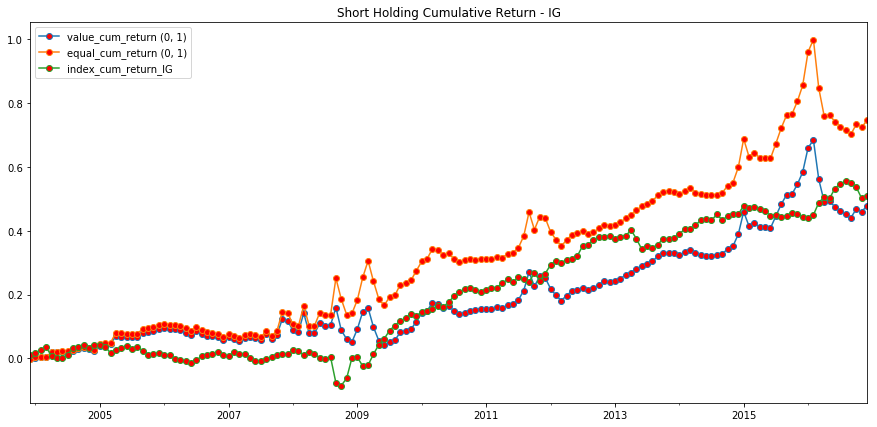

In [17]:
title_txt = 'Short Holding Cumulative Return - IG'
risk_weight_index_short_IG.iloc[:, [2,3,6]].plot(figsize=(15,7), title = title_txt, 
                           style='.-', markevery=1, marker='o', markerfacecolor='red')

In [18]:
weight_test_long_IG = weight_type_test(perf_test_weight_long_holing_IG)
risk_weight_test_long_IG, risk_weight_index_long_IG = get_risk_indicator(perf_test_weight_long_holing_IG, data_universe)

In [19]:
weight_test_long_IG.round(5)

,"value_return (0, 6)","equal_return (0, 6)",Result1,Result2
Correlation,0.97531,0.97531,Positive correlation,Positive correlation
Shapiro (Gaussian),0.00000,0.00000,No,No
Adfuller (stationary),0.00301,0.00105,Yes,Yes
T-test (mean),0.66048,0.66048,Equal,Equal


In [20]:
risk_weight_test_long_IG

,"value_return (0, 6)","equal_return (0, 6)"
Excess annual return,-0.0151747,-0.00388361
Excess cumulative return,-0.181316,-0.0496353
Excess mean return,-0.00127344,-0.000324211
Volatility,0.0187366,0.0206706
Annualized Sharpe ratio,-0.0584783,-0.00530325
Alpha,9.68048e-05,0.00150958
Beta,-0.438676,-0.595649
Skewness,-0.819665,-0.212321
Kurtosis,4.70038,4.0615
MaxDD,-0.242685,-0.199539


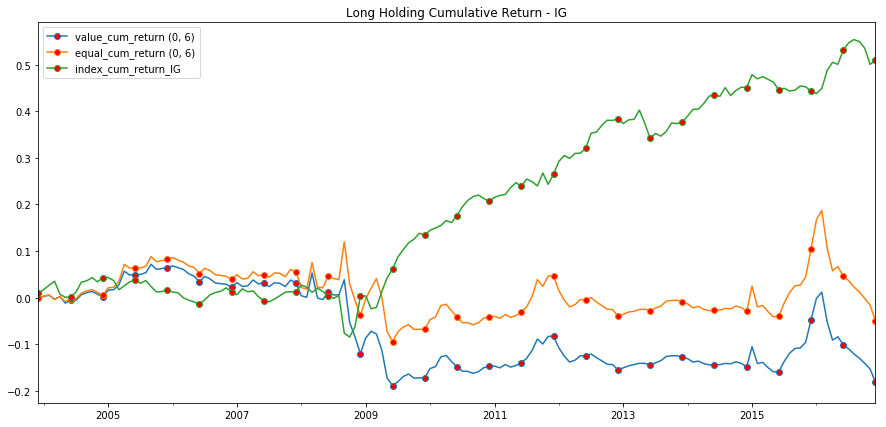

In [21]:
title_txt = 'Long Holding Cumulative Return - IG'
risk_weight_index_long_IG.iloc[:, [2,3,6]].plot(figsize=(15,7), title = title_txt, 
                           style='.-', markevery=6, marker='o', markerfacecolor='red')

# BBB universe

In [22]:
data_universe = 'BBB'

In [23]:
perf_test_weight_short_holing_BBB = performance_backtest(formation_date, data_universe, avg_range, holding_range_s, test_period, TMT)

In [24]:
perf_test_weight_long_holing_BBB = performance_backtest(formation_date, data_universe, avg_range, holding_range_l, test_period, TMT)

In [25]:
weight_test_short_BBB = weight_type_test(perf_test_weight_short_holing_BBB)
risk_weight_test_short_BBB, risk_weight_index_short_BBB = get_risk_indicator(perf_test_weight_short_holing_BBB, data_universe)

In [26]:
weight_test_short_BBB.round(5)

,"value_return (0, 1)","equal_return (0, 1)",Result1,Result2
Correlation,0.98945,0.98945,Positive correlation,Positive correlation
Shapiro (Gaussian),0.00000,0.00000,No,No
Adfuller (stationary),0.00000,0.00000,Yes,Yes
T-test (mean),0.71078,0.71078,Equal,Equal


In [27]:
risk_weight_test_short_BBB

,"value_return (0, 1)","equal_return (0, 1)"
Excess annual return,0.0518668,0.0618583
Excess cumulative return,0.937849,1.19299
Excess mean return,0.00422277,0.00501423
Volatility,0.0187098,0.0207795
Annualized Sharpe ratio,0.235023,0.251628
Alpha,0.00455638,0.0055567
Beta,-0.0425886,-0.0877733
Skewness,0.0105425,0.226616
Kurtosis,4.87231,5.52722
MaxDD,-0.133115,-0.134733


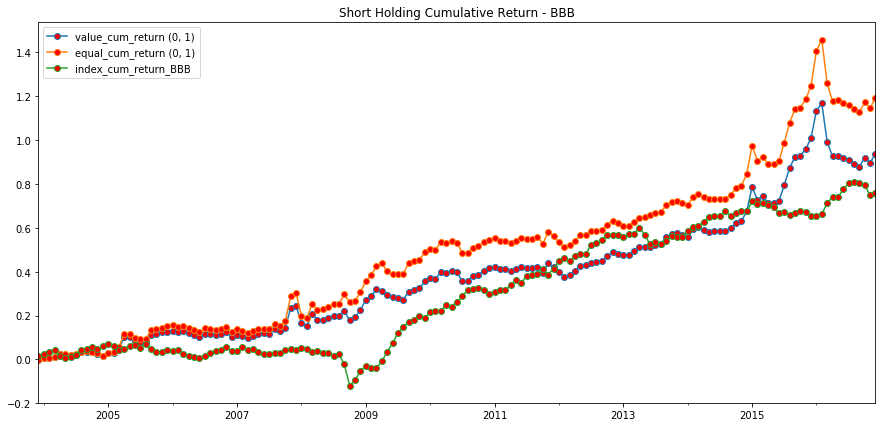

In [28]:
title_txt = 'Short Holding Cumulative Return - BBB'
risk_weight_index_short_BBB.iloc[:, [2,3,6]].plot(figsize=(15,7), title = title_txt, 
                           style='.-', markevery=1, marker='o', markerfacecolor='red')

In [29]:
weight_test_long_BBB = weight_type_test(perf_test_weight_long_holing_BBB)
risk_weight_test_long_BBB, risk_weight_index_long_BBB = get_risk_indicator(perf_test_weight_long_holing_BBB, data_universe)

In [30]:
weight_test_long_BBB.round(5)

,"value_return (0, 6)","equal_return (0, 6)",Result1,Result2
Correlation,0.99333,0.99333,Positive correlation,Positive correlation
Shapiro (Gaussian),0.00000,0.00000,No,No
Adfuller (stationary),0.00000,0.00000,Yes,Yes
T-test (mean),0.81868,0.81868,Equal,Equal


In [31]:
risk_weight_test_long_BBB

,"value_return (0, 6)","equal_return (0, 6)"
Excess annual return,-0.0026158,0.00316016
Excess cumulative return,-0.0336877,0.0421441
Excess mean return,-0.000218245,0.000262966
Volatility,0.0189154,0.0205344
Annualized Sharpe ratio,-0.00205249,0.0231094
Alpha,-5.38351e-05,0.000582582
Beta,0.0040172,-0.0289137
Skewness,-0.1326,-0.179886
Kurtosis,4.23893,4.63761
MaxDD,-0.206905,-0.213454


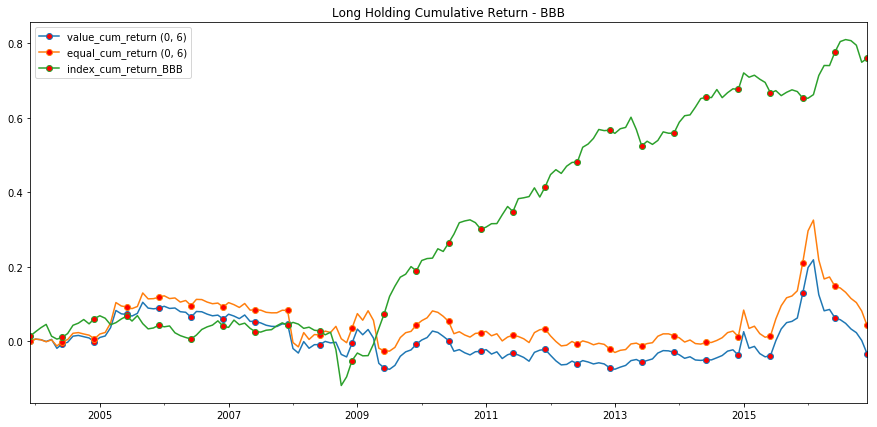

In [32]:
title_txt = 'Long Holding Cumulative Return - BBB'
risk_weight_index_long_BBB.iloc[:, [2,3,6]].plot(figsize=(15,7), title = title_txt, 
                           style='.-', markevery=6, marker='o', markerfacecolor='red')

# HY universe

In [33]:
data_universe = 'HY'

In [34]:
perf_test_weight_short_holing_HY = performance_backtest(formation_date, data_universe, avg_range, holding_range_s, test_period, TMT)
perf_test_weight_long_holing_HY = performance_backtest(formation_date, data_universe, avg_range, holding_range_l, test_period, TMT)

In [35]:
weight_test_short_HY = weight_type_test(perf_test_weight_short_holing_HY)
risk_weight_test_short_HY, risk_weight_index_short_HY = get_risk_indicator(perf_test_weight_short_holing_HY, data_universe)

In [36]:
weight_test_short_HY.round(5)

,"value_return (0, 1)","equal_return (0, 1)",Result1,Result2
Correlation,0.94774,0.94774,Positive correlation,Positive correlation
Shapiro (Gaussian),0.00000,0.00000,No,No
Adfuller (stationary),0.00000,0.00000,Yes,Yes
T-test (mean),0.57627,0.57627,Equal,Equal


In [37]:
risk_weight_test_short_HY

,"value_return (0, 1)","equal_return (0, 1)"
Excess annual return,0.0947899,0.139537
Excess cumulative return,2.27023,4.52329
Excess mean return,0.00757542,0.0109446
Volatility,0.0530696,0.0527328
Annualized Sharpe ratio,0.168387,0.232899
Alpha,0.0109731,0.0135527
Beta,-0.357707,-0.223262
Skewness,1.03516,1.05654
Kurtosis,6.80109,5.84772
MaxDD,-0.278786,-0.222992


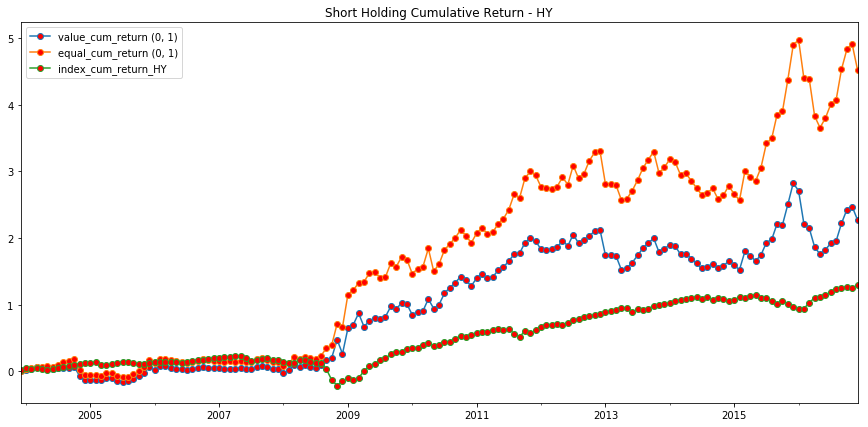

In [38]:
title_txt = 'Short Holding Cumulative Return - HY'
risk_weight_index_short_HY.iloc[:, [2,3,6]].plot(figsize=(15,7), title = title_txt, 
                           style='.-', markevery=1, marker='o', markerfacecolor='red')

In [39]:
weight_test_long_HY = weight_type_test(perf_test_weight_long_holing_HY)
risk_weight_test_long_HY, risk_weight_index_long_HY = get_risk_indicator(perf_test_weight_long_holing_HY, data_universe)

In [40]:
weight_test_long_HY.round(5)

,"value_return (0, 6)","equal_return (0, 6)",Result1,Result2
Correlation,0.93593,0.93593,Positive correlation,Positive correlation
Shapiro (Gaussian),0.00000,0.00000,No,No
Adfuller (stationary),0.00000,0.00000,Yes,Yes
T-test (mean),0.50711,0.50711,Equal,Equal


In [41]:
risk_weight_test_long_HY

,"value_return (0, 6)","equal_return (0, 6)"
Excess annual return,0.0451419,0.0929594
Excess cumulative return,0.781872,2.19941
Excess mean return,0.00368617,0.00743493
Volatility,0.0512693,0.0585301
Annualized Sharpe ratio,0.0971067,0.155722
Alpha,0.0055874,0.00891525
Beta,-0.106917,0.0349822
Skewness,0.733365,0.639938
Kurtosis,8.62127,6.31284
MaxDD,-0.448239,-0.442898


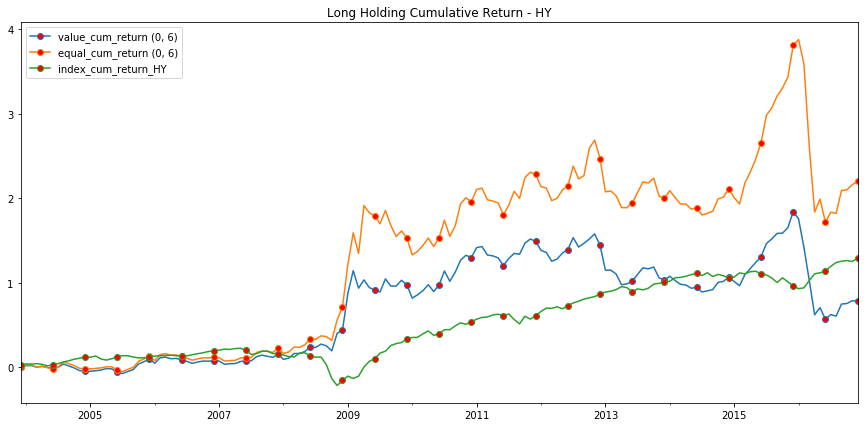

In [42]:
title_txt = 'Long Holding Cumulative Return - HY'
risk_weight_index_long_HY.iloc[:, [2,3,6]].plot(figsize=(15,7), title = title_txt, 
                           style='.-', markevery=6, marker='o', markerfacecolor='red')

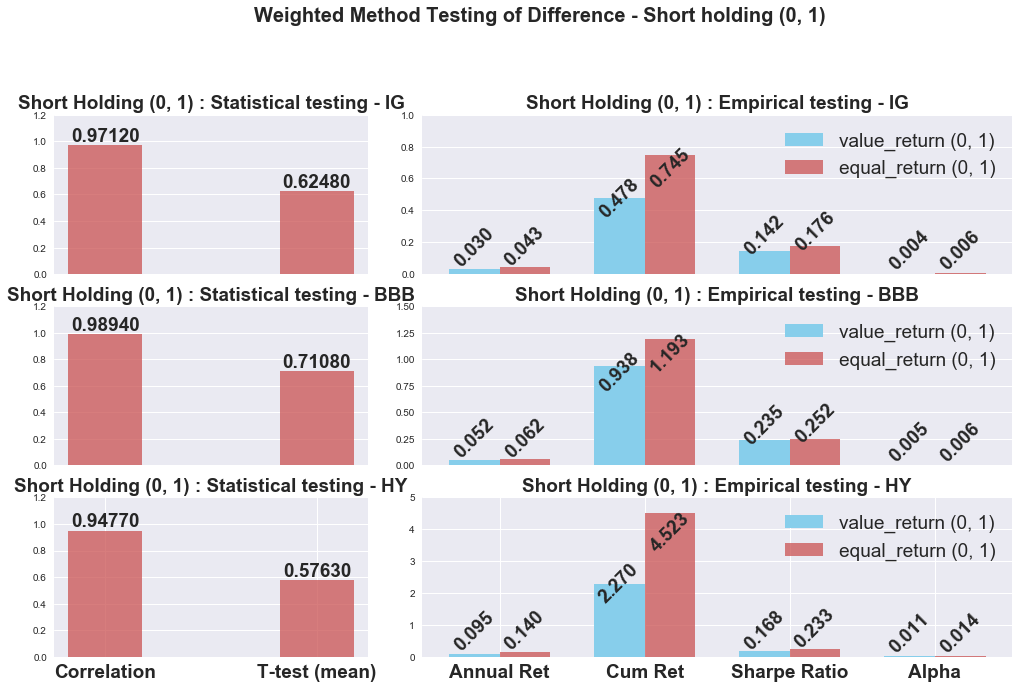

In [48]:
style.use('seaborn')

fig = plt.figure(figsize=(18, 15))
fig.suptitle('Weighted Method Testing of Difference - Short holding (0, 1)', fontsize=20, fontweight='bold')

ax1 = plt.subplot2grid((30, 22), (0, 0), rowspan=6, colspan=7)

index = np.arange(2)
bar_width = 0.35
opacity = 0.8

rect11 = ax1.bar(index, weight_test_short_IG.iloc[[0,3], 1].round(4).values, bar_width, color='IndianRed', alpha=opacity, label="{0}".format(weight_test_short_IG.columns[0]))
for rect in rect11:
    height1 = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width()/2, height1,
                "{0:0.5f}".format(height1),
                ha='center', va='bottom', fontsize=19, weight='bold')

ax1.set_ylim([0, 1.2])
ax1.xaxis.set_visible(False)
ax1.set_title('Short Holding (0, 1) : Statistical testing - IG', fontsize=19, weight='bold')
    
ax2 = plt.subplot2grid((30, 22), (0, 8), rowspan=6, colspan=13)

index = np.arange(4)
bar_width = 0.35
opacity = 0.8

rect12 = ax2.bar(index - bar_width/2, risk_weight_test_short_IG.iloc[[0,1,4,5], 0].values, bar_width, color='SkyBlue', label="{0}".format(risk_weight_test_short_IG.columns[0]))
for rect in rect12:
    height1 = rect.get_height()
    ax2.text(rect.get_x() + rect.get_width()/2., 0.7*height1,
                "{0:0.3f}".format(height1),
                ha='center', va='bottom', fontsize=19, rotation=45, weight='bold')

rect22 = ax2.bar(index + bar_width/2, risk_weight_test_short_IG.iloc[[0,1,4,5], 1].values, bar_width, color='IndianRed', alpha=opacity, label="{0}".format(risk_weight_test_short_IG.columns[1]))
for rect in rect22:
    height2 = rect.get_height()
    ax2.text(rect.get_x() + rect.get_width()/2., 0.7*height2,
                "{0:0.3f}".format(height2),
                ha='center', va='bottom', fontsize=19, rotation=45, weight='bold')
#ax2.set_xticks(index)
#ax2.set_xticklabels((risk_weight_test_long_IG.index[0],risk_weight_test_long_IG.index[1],
#                    risk_weight_test_long_IG.index[4], risk_weight_test_long_IG.index[5],
#                    risk_weight_test_long_IG.index[6]), fontsize=15)
ax2.set_ylim([0, 1])
ax2.xaxis.set_visible(False)
ax2.set_title('Short Holding (0, 1) : Empirical testing - IG', fontsize=19, weight='bold')
ax2.legend(fontsize=19)

##################################################################################################################       
           
ax3 = plt.subplot2grid((30, 22), (7, 0), rowspan=6, colspan=7, sharex=ax1)

index = np.arange(2)
bar_width = 0.35
opacity = 0.8

rect13 = ax3.bar(index, weight_test_short_BBB.iloc[[0,3], 1].round(4).values, bar_width, color='IndianRed', alpha=opacity, label="{0}".format(weight_test_short_IG.columns[0]))
for rect in rect13:
    height1 = rect.get_height()
    ax3.text(rect.get_x() + rect.get_width()/2., height1,
                "{0:0.5f}".format(height1),
                ha='center', va='bottom', fontsize=19, weight='bold')

#ax1.set_xticks(index)
#ax1.set_xticklabels((weight_test_long_IG.index[0], weight_test_long_IG.index[3]), fontsize=15)
ax3.set_ylim([0, 1.2])
ax3.xaxis.set_visible(False)
ax3.set_title('Short Holding (0, 1) : Statistical testing - BBB', fontsize=19, weight='bold')
    
ax4 = plt.subplot2grid((30, 22), (7, 8), rowspan=6, colspan=13, sharex=ax2)

index = np.arange(4)
bar_width = 0.35
opacity = 0.8

rect14 = ax4.bar(index - bar_width/2, risk_weight_test_short_BBB.iloc[[0,1,4,5], 0].values, bar_width, color='SkyBlue', label="{0}".format(risk_weight_test_short_IG.columns[0]))
for rect in rect14:
    height1 = rect.get_height()
    ax4.text(rect.get_x() + rect.get_width()/2., 0.7*height1,
                "{0:0.3f}".format(height1),
                ha='center', va='bottom', fontsize=19, rotation=45, weight='bold')

rect24 = ax4.bar(index + bar_width/2, risk_weight_test_short_BBB.iloc[[0,1,4,5], 1].values, bar_width, color='IndianRed', alpha=opacity, label="{0}".format(risk_weight_test_short_IG.columns[1]))
for rect in rect24:
    height2 = rect.get_height()
    ax4.text(rect.get_x() + rect.get_width()/2., 0.7*height2,
                "{0:0.3f}".format(height2),
                ha='center', va='bottom', fontsize=19, rotation=45, weight='bold')
#ax2.set_xticks(index)
#ax2.set_xticklabels((risk_weight_test_long_IG.index[0],risk_weight_test_long_IG.index[1],
#                    risk_weight_test_long_IG.index[4], risk_weight_test_long_IG.index[5],
#                    risk_weight_test_long_IG.index[6]), fontsize=15)
ax4.set_ylim([0, 1.5])
ax4.xaxis.set_visible(False)
ax4.set_title('Short Holding (0, 1) : Empirical testing - BBB', fontsize=19, weight='bold')
ax4.legend(fontsize=19)
##################################################################################################################       
         
ax5 = plt.subplot2grid((30, 22), (14, 0), rowspan=6, colspan=7, sharex=ax1)

index = np.arange(2)
bar_width = 0.35
opacity = 0.8

rect15 = ax5.bar(index, weight_test_short_HY.iloc[[0,3], 1].round(4).values, bar_width, color='IndianRed', alpha=opacity, label="{0}".format(weight_test_short_IG.columns[1]))
for rect in rect15:
    height2 = rect.get_height()
    ax5.text(rect.get_x() + rect.get_width()/2., height2,
                "{0:0.5f}".format(height2),
                ha='center', va='bottom', fontsize=19, weight='bold')
ax5.set_xticks(index)
ax5.set_xticklabels((weight_test_short_IG.index[0], weight_test_short_IG.index[3]), fontsize=19, weight='bold')
ax5.set_ylim([0, 1.2])
ax5.set_title('Short Holding (0, 1) : Statistical testing - HY', fontsize=19, weight='bold')
    
ax6 = plt.subplot2grid((30, 22), (14, 8), rowspan=6, colspan=13, sharex=ax2)

index = np.arange(4)
bar_width = 0.35
opacity = 0.8

rect16 = ax6.bar(index - bar_width/2, risk_weight_test_short_HY.iloc[[0,1,4,5], 0].values, bar_width, color='SkyBlue', label="{0}".format(risk_weight_test_short_IG.columns[0]))
for rect in rect16:
    height1 = rect.get_height()
    ax6.text(rect.get_x() + rect.get_width()/2., 0.7*height1,
                "{0:0.3f}".format(height1),
                ha='center', va='bottom', fontsize=19, rotation=45, weight='bold')

rect26 = ax6.bar(index + bar_width/2, risk_weight_test_short_HY.iloc[[0,1,4,5], 1].values, bar_width, color='IndianRed', alpha=opacity, label="{0}".format(risk_weight_test_short_IG.columns[1]))
for rect in rect26:
    height2 = rect.get_height()
    ax6.text(rect.get_x() + rect.get_width()/2., 0.7*height2,
                "{0:0.3f}".format(height2),
                ha='center', va='bottom', fontsize=19, rotation=45, weight='bold')
ax6.set_ylim([0, 5])
ax6.set_xticks(index)
ax6.set_xticklabels(('Annual Ret', 'Cum Ret', 'Sharpe Ratio', 'Alpha'), fontsize=19, weight='bold')
ax6.set_title('Short Holding (0, 1) : Empirical testing - HY', fontsize=19, weight='bold')
ax6.legend(fontsize=19)

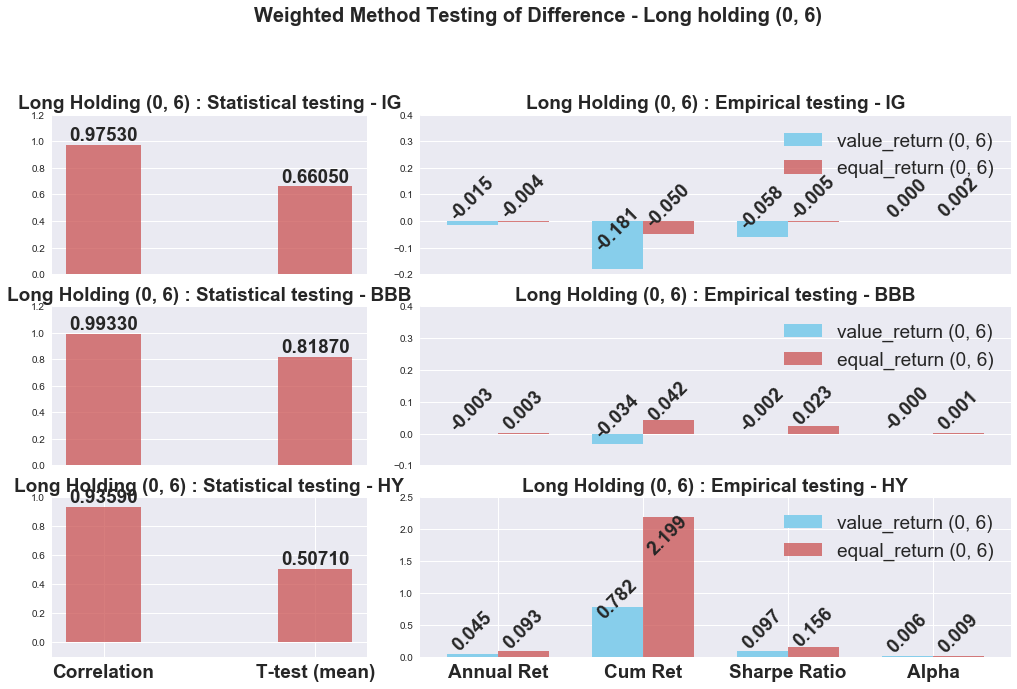

In [50]:
style.use('seaborn')

fig = plt.figure(figsize=(18, 15))
strat_name = np.where(strat_type == 0, 'Total', 'Residual')
fig.suptitle('Weighted Method Testing of Difference - Long holding (0, 6)', fontsize=20, fontweight='bold')

ax1 = plt.subplot2grid((30, 22), (0, 0), rowspan=6, colspan=7)

index = np.arange(2)
bar_width = 0.35
opacity = 0.8

rect11 = ax1.bar(index, weight_test_long_IG.iloc[[0,3], 1].round(4).values, bar_width, color='IndianRed', alpha=opacity, label="{0}".format(weight_test_long_IG.columns[0]))
for rect in rect11:
    height1 = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width()/2, height1,
                "{0:0.5f}".format(height1),
                ha='center', va='bottom', fontsize=19, weight='bold')

#ax1.set_xticks(index)
#ax1.set_xticklabels((weight_test_long_IG.index[0], weight_test_long_IG.index[3]), fontsize=15)
ax1.set_ylim([0, 1.2])
ax1.xaxis.set_visible(False)
ax1.set_title('Long Holding (0, 6) : Statistical testing - IG', fontsize=19, weight='bold')
    
ax2 = plt.subplot2grid((30, 22), (0, 8), rowspan=6, colspan=13)

index = np.arange(4)
bar_width = 0.35
opacity = 0.8

rect12 = ax2.bar(index - bar_width/2, risk_weight_test_long_IG.iloc[[0,1,4,5], 0].values, bar_width, color='SkyBlue', label="{0}".format(risk_weight_test_long_IG.columns[0]))
for rect in rect12:
    height1 = rect.get_height()
    ax2.text(rect.get_x() + rect.get_width()/2., 0.7*height1,
                "{0:0.3f}".format(height1),
                ha='center', va='bottom', fontsize=19, rotation=45, weight='bold')

rect22 = ax2.bar(index + bar_width/2, risk_weight_test_long_IG.iloc[[0,1,4,5], 1].values, bar_width, color='IndianRed', alpha=opacity, label="{0}".format(risk_weight_test_long_IG.columns[1]))
for rect in rect22:
    height2 = rect.get_height()
    ax2.text(rect.get_x() + rect.get_width()/2., 0.7*height2,
                "{0:0.3f}".format(height2),
                ha='center', va='bottom', fontsize=19, rotation=45, weight='bold')
#ax2.set_xticks(index)
#ax2.set_xticklabels((risk_weight_test_long_IG.index[0],risk_weight_test_long_IG.index[1],
#                    risk_weight_test_long_IG.index[4], risk_weight_test_long_IG.index[5],
#                    risk_weight_test_long_IG.index[6]), fontsize=15)
ax2.set_ylim([-0.2, 0.4])
ax2.xaxis.set_visible(False)
ax2.set_title('Long Holding (0, 6) : Empirical testing - IG', fontsize=19, weight='bold')
ax2.legend(fontsize=19)

##################################################################################################################       
           
ax3 = plt.subplot2grid((30, 22), (7, 0), rowspan=6, colspan=7, sharex=ax1)

index = np.arange(2)
bar_width = 0.35
opacity = 0.8

rect13 = ax3.bar(index, weight_test_long_BBB.iloc[[0,3], 1].round(4).values, bar_width, color='IndianRed', alpha=opacity, label="{0}".format(weight_test_long_IG.columns[0]))
for rect in rect13:
    height1 = rect.get_height()
    ax3.text(rect.get_x() + rect.get_width()/2., height1,
                "{0:0.5f}".format(height1),
                ha='center', va='bottom', fontsize=19, weight='bold')

#ax1.set_xticks(index)
#ax1.set_xticklabels((weight_test_long_IG.index[0], weight_test_long_IG.index[3]), fontsize=15)
ax3.set_ylim([0, 1.2])
ax3.xaxis.set_visible(False)
ax3.set_title('Long Holding (0, 6) : Statistical testing - BBB', fontsize=19, weight='bold')
    
ax4 = plt.subplot2grid((30, 22), (7, 8), rowspan=6, colspan=13, sharex=ax2)

index = np.arange(4)
bar_width = 0.35
opacity = 0.8

rect14 = ax4.bar(index - bar_width/2, risk_weight_test_long_BBB.iloc[[0,1,4,5], 0].values, bar_width, color='SkyBlue', label="{0}".format(risk_weight_test_long_IG.columns[0]))
for rect in rect14:
    height1 = rect.get_height()
    ax4.text(rect.get_x() + rect.get_width()/2., 0.7*height1,
                "{0:0.3f}".format(height1),
                ha='center', va='bottom', fontsize=19, rotation=45, weight='bold')

rect24 = ax4.bar(index + bar_width/2, risk_weight_test_long_BBB.iloc[[0,1,4,5], 1].values, bar_width, color='IndianRed', alpha=opacity, label="{0}".format(risk_weight_test_long_IG.columns[1]))
for rect in rect24:
    height2 = rect.get_height()
    ax4.text(rect.get_x() + rect.get_width()/2., 0.7*height2,
                "{0:0.3f}".format(height2),
                ha='center', va='bottom', fontsize=19, rotation=45, weight='bold')
#ax2.set_xticks(index)
#ax2.set_xticklabels((risk_weight_test_long_IG.index[0],risk_weight_test_long_IG.index[1],
#                    risk_weight_test_long_IG.index[4], risk_weight_test_long_IG.index[5],
#                    risk_weight_test_long_IG.index[6]), fontsize=15)
ax4.set_ylim([-0.1, 0.4])
ax4.xaxis.set_visible(False)
ax4.set_title('Long Holding (0, 6) : Empirical testing - BBB', fontsize=19, weight='bold')
ax4.legend(fontsize=19)
           
##################################################################################################################       
         
ax5 = plt.subplot2grid((30, 22), (14, 0), rowspan=6, colspan=7, sharex=ax1)

index = np.arange(2)
bar_width = 0.35
opacity = 0.8

rect15 = ax5.bar(index, weight_test_long_HY.iloc[[0,3], 1].round(4).values, bar_width, color='IndianRed', alpha=opacity, label="{0}".format(weight_test_long_IG.columns[1]))
for rect in rect15:
    height2 = rect.get_height()
    ax5.text(rect.get_x() + rect.get_width()/2., height2,
                "{0:0.5f}".format(height2),
                ha='center', va='bottom', fontsize=19, weight='bold')
ax5.set_xticks(index)
ax5.set_xticklabels((weight_test_long_IG.index[0], weight_test_long_IG.index[3]), fontsize=19, weight='bold')
ax5.set_ylim([-0.1, 1])
ax5.set_title('Long Holding (0, 6) : Statistical testing - HY', fontsize=19, weight='bold')
    
ax6 = plt.subplot2grid((30, 22), (14, 8), rowspan=6, colspan=13, sharex=ax2)

index = np.arange(4)
bar_width = 0.35
opacity = 0.8

rect16 = ax6.bar(index - bar_width/2, risk_weight_test_long_HY.iloc[[0,1,4,5], 0].values, bar_width, color='SkyBlue', label="{0}".format(risk_weight_test_long_IG.columns[0]))
for rect in rect16:
    height1 = rect.get_height()
    ax6.text(rect.get_x() + rect.get_width()/2., 0.7*height1,
                "{0:0.3f}".format(height1),
                ha='center', va='bottom', fontsize=19, rotation=45, weight='bold')

rect26 = ax6.bar(index + bar_width/2, risk_weight_test_long_HY.iloc[[0,1,4,5], 1].values, bar_width, color='IndianRed', alpha=opacity, label="{0}".format(risk_weight_test_long_IG.columns[1]))
for rect in rect26:
    height2 = rect.get_height()
    ax6.text(rect.get_x() + rect.get_width()/2., 0.7*height2,
                "{0:0.3f}".format(height2),
                ha='center', va='bottom', fontsize=19, rotation=45, weight='bold')
ax6.set_ylim([0, 2.5])
ax6.set_xticks(index)
ax6.set_xticklabels(('Annual Ret', 'Cum Ret', 'Sharpe Ratio', 'Alpha',), fontsize=19, weight='bold')
ax6.set_title('Long Holding (0, 6) : Empirical testing - HY', fontsize=19, weight='bold')
ax6.legend(fontsize=19)
           